In [1]:
# Import libraries
import numpy as np
import pandas as pd
import sklearn
import nltk
import re
import os
import sys
import random
import graphviz
import matplotlib.pyplot as plt
import pydotplus
import seaborn as sns
import string

from nltk.probability import FreqDist
from nltk.corpus import stopwords, sentence_polarity
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.collocations import*
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('stopwords')

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline

from IPython.display import Image
from wordcloud import WordCloud




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/likhithkolli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/likhithkolli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau



In [3]:
##TEXT PRE-PROCESSING - Reading in the data and making it into a compatible format

'''
  This program shell reads email data for the spam classification problem.
  The input to the program is the path to the Email directory "corpus" and a limit number.

  Usage:  python classifySPAM.py   
'''

dirPath = '/Users/likhithkolli/Downloads/FinalProjectData/EmailSpamCorpora/corpus'

# function to read spam and ham files, train and test a classifier
def processSpamHam(dirPath,limitStr):
  # convert the limit argument from a string to an int
  limit = int(limitStr)
  # initialize lists for spam and ham email texts
  hamtexts = []
  spamtexts = []
  os.chdir(dirPath)
  # process all files in directory that end in .txt up to the provided limit
  #    assuming that the emails are sufficiently randomized
  # output: spamtexts, hamtexts
  #    list in which each list item is an entire email stored in one string
  for file in os.listdir("./spam"):
    if (file.endswith(".txt")) and (len(spamtexts) < limit):
      # open file for reading and read entire file into a string
      f = open("./spam/"+file, 'r', encoding="latin-1")
      spamtexts.append (f.read())
      f.close()
  for file in os.listdir("./ham"):
    if (file.endswith(".txt")) and (len(hamtexts) < limit):
      # open file for reading and read entire file into a string
      f = open("./ham/"+file, 'r', encoding="latin-1")
      hamtexts.append (f.read())
      f.close()

  # print number emails read
  print ("Number of spam files:",len(spamtexts))
  print ("Number of ham files:",len(hamtexts))

  # output: emaildocs
  #     single list of mixed spam and ham email documents as
  #     list items are: (list of tokenized words, label)
  emaildocs = []
  # add the spam
  for spam in spamtexts:
    tokens = nltk.word_tokenize(spam)
    emaildocs.append((tokens, 'spam'))
  # add the ham
  for ham in hamtexts:
    tokens = nltk.word_tokenize(ham)
    emaildocs.append((tokens, 'ham'))

  # randomize the list
  random.shuffle(emaildocs)

  # print a few token lists
  """
  for email in emaildocs[:4]:
    print (email)
    print
  """

  return(emaildocs, spamtexts, hamtexts)

In [4]:
def cleanUpCleanUp(emaildocs):
  # everybody do your share, everybody everywhere

  # output: spamTokens, hamTokens
  #     each list will contain tokenized words sorted by spam or ham

  # initialize word lists for all tokenized words from master emaildocs list
  # make everything lowercase for more accurate frequency analysis
  spamTokens = []
  hamTokens = []
  emaildocsTokenized = []
  for item in emaildocs:
    email = item[0]
    if item[1] == "spam":
      for word in email:
        spamTokens.append(word.lower())
    else:
      for word in email:
        hamTokens.append(word.lower())

  tokenList = []
  for item in emaildocs:
    email = item[0]
    for word in email:
      tokenList.append(word.lower())
    emaildocsTokenized.append((tokenList,item[1]))
    tokenList = []

  # regex filter
  # output: spamAlpha, hamAlpha
  #     each list will contain only words with all alphabetized chars sorted by spam or ham
  # initialize word lists for alpha words
  spamAlpha = []
  hamAlpha = []
  emaildocsAlpha = []
  pattern = re.compile('^[^a-z]+$')
  for word in hamTokens:
    if not pattern.match(word):
      hamAlpha.append(word)
  for word in spamTokens:
    if not pattern.match(word):
      spamAlpha.append(word)

  alphaList = []
  for item in emaildocsTokenized:
    emailTokenList = item[0]
    for word in emailTokenList:
      if not pattern.match(word):
        alphaList.append(word)
    emaildocsAlpha.append((alphaList,item[1]))
    alphaList = []

  # checkout default stopword file to see if it will accomplish desired goals
  nltk.download('stopwords')
  nltkStopwords = nltk.corpus.stopwords.words('english')
  # print(nltkStopwords)

  #adding some of our own stopwords to tailor the list to our needs
  # specifically, adding names of recipients that are showing up in most frequent
  # removing recipients so that this is helpful to all bodies of email, not just ones with those names
  moreStopwords = ['daren','hou','ect','subject','could','would','might','must','need','sha','wo','y',"'s","'d","'ll","'t","'m","'re","'ve"]
  stopwords = nltkStopwords + moreStopwords

  # using the list filtered for just alphabetic chars
  hamStop = [w for w in hamAlpha if not w in stopwords]
  spamStop = [w for w in spamAlpha if not w in stopwords]

  emaildocsStop = []
  for item in emaildocsAlpha:
    emailTokenList = item[0]
    stopList = [w for w in emailTokenList if not w in stopwords]
    emaildocsStop.append((stopList,item[1]))
    stopList = []

  # if we want to use our own stopword file, read stop word file
  """
  fstop = open('stopwordFinal.stop','r')
  stoptext = fstop.read()
  fstop.close()
  stopwords = nltk.word_tokenize(stoptext)
  """
  return(hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop)


In [5]:
def trainTestSplit(emaildocsStop):
    prepList = []
    trainList = []
    testList = []
    listA = []
    # change ham = 0, spam = 1
    for email in emaildocsStop:
        if email[1] == "ham":
            listA = [email[0],0]
            prepList.append(listA)
        else:
            listA = [email[0],1]
            prepList.append(listA)
        listA = []

    # use numpy to get a random selection of 75% of data for training
    for item in prepList:
        if numpy.random.uniform(0,1) < 0.75:
            trainList.append(item)
        else:
            testList.append(item)
    print(len(testList))
    print(len(trainList))

    return testList, trainList

In [6]:
def join(testList, trainList):
    # joining our tokenized list values for vectorization and training
    joinedTestList = []
    joinedTrainList = []
    listA = []
    for email in testList:
        joinedString = ' '.join(email[0])
        listA = [joinedString,email[1]]
        joinedTestList.append(listA)
        listA = []

    for email in trainList:
        joinedString = ' '.join(email[0])
        listA = [joinedString,email[1]]
        joinedTrainList.append(listA)
        listA = []

    return joinedTestList, joinedTrainList

In [7]:
import os
import csv

# Function to read files from a directory
def read_files_from_directory(directory):
    file_texts = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r', encoding='latin-1') as file:
                text = file.read()
                file_texts.append((text, filename))
    return file_texts

# Define your directories for ham and spam files
ham_directory = "/Users/likhithkolli/Downloads/FinalProjectData/EmailSpamCorpora/corpus/ham"
spam_directory = "/Users/likhithkolli/Downloads/FinalProjectData/EmailSpamCorpora/corpus/spam"

# Read files from directories
ham_files = read_files_from_directory(ham_directory)
spam_files = read_files_from_directory(spam_directory)

# Write data to CSV file
with open("out.csv", 'w', newline='', encoding='utf-8') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Category', 'Message'])
    
    # Write ham messages
    for text, filename in ham_files:
        csvwriter.writerow(['ham', text])
    
    # Write spam messages
    for text, filename in spam_files:
        csvwriter.writerow(['spam', text])

print("CSV file created successfully.")


CSV file created successfully.


In [8]:
def frequencyAnalysis(hamList,spamList):
  ndist = FreqDist(hamList)
  nitems = ndist.most_common(30)
  print("\nHam Most Common Words")
  for item in nitems:
    print(item[0],'\t',item[1])

  ndist2 = FreqDist(spamList)
  nitems2 = ndist2.most_common(30)
  print("\nSpam Most Common Words")
  for item in nitems2:
    print(item[0],'\t',item[1])

In [9]:
# Example directory path and limit
directory_path = '/Users/likhithkolli/Downloads/FinalProjectData/EmailSpamCorpora/corpus'
limit = 3672  # Example limit

emaildocs, spamtexts, hamtexts = processSpamHam(directory_path, limit)
hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop = cleanUpCleanUp(emaildocs)

print("Frequency Analysis with symbols/numbers removed and stopwords filtered:")
frequencyAnalysis(hamStop, spamStop)


Number of spam files: 1500
Number of ham files: 3672


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/likhithkolli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Frequency Analysis with symbols/numbers removed and stopwords filtered:

Ham Most Common Words
enron 	 6555
gas 	 2861
deal 	 2789
com 	 2717
please 	 2715
meter 	 2459
cc 	 2359
pm 	 2325
hpl 	 2318
thanks 	 1813
corp 	 1710
know 	 1438
mmbtu 	 1349
e 	 1338
j 	 1300
forwarded 	 1296
farmer 	 1137
let 	 1086
attached 	 1083
xls 	 1020
see 	 1018
new 	 1003
may 	 960
l 	 923
contract 	 883
volume 	 877
robert 	 875
day 	 874
sitara 	 861
nom 	 831

Spam Most Common Words
com 	 993
http 	 983
company 	 731
e 	 638
www 	 587
information 	 520
font 	 515
td 	 504
get 	 486
please 	 485
statements 	 476
email 	 475
price 	 471
us 	 471
new 	 434
may 	 423
nbsp 	 418
one 	 392
p 	 391
height 	 362
time 	 361
free 	 314
within 	 313
pills 	 311
r 	 306
size 	 306
width 	 306
stock 	 299
b 	 298
message 	 297


In [10]:
#feature function 2: bigram frequency analysis

def bigrams(hamList, spamList):
  hamFinder = nltk.collocations.BigramCollocationFinder.from_words(hamList)
  commonBigrams = hamFinder.ngram_fd.most_common(30)
  print("\nHam Most Common Bigrams")
  for bigram in commonBigrams:
    print(bigram[0],'\t', bigram[1])

  spamFinder = nltk.collocations.BigramCollocationFinder.from_words(spamList)
  commonBigrams = spamFinder.ngram_fd.most_common(30)
  print("\nSpam Most Common Bigrams")
  for bigram in commonBigrams:
    print(bigram[0],'\t',bigram[1])


In [11]:
import random  # Ensure all necessary modules are imported

# Example directory path and limit
#directory_path = '/path/to/your/email/directory'
limit = 3700  # Example limit

# Process spam and ham emails
emaildocs, spamtexts, hamtexts = processSpamHam(directory_path, limit)

# Clean up and tokenize emails
hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop = cleanUpCleanUp(emaildocs)

# Generate and print top 30 bigrams
print("Top 30 bigrams using list with symbols/numbers removed and stopwords filtered:")
bigrams(hamStop,spamStop)


Number of spam files: 1500
Number of ham files: 3672


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/likhithkolli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 30 bigrams using list with symbols/numbers removed and stopwords filtered:

Ham Most Common Bigrams
('enron', 'enron') 	 1449
('corp', 'enron') 	 1214
('let', 'know') 	 937
('enron', 'com') 	 831
('j', 'farmer') 	 816
('see', 'attached') 	 572
('e', 'mail') 	 504
('attached', 'file') 	 502
('please', 'let') 	 452
('original', 'message') 	 437
('enron', 'hpl') 	 396
('pec', 'pec') 	 357
('teco', 'tap') 	 333
('enron', 'cc') 	 314
('ami', 'chokshi') 	 308
('gas', 'daily') 	 303
('north', 'america') 	 302
('tenaska', 'iv') 	 299
('enron', 'north') 	 287
('vance', 'l') 	 286
('robert', 'cotten') 	 285
('l', 'taylor') 	 276
('pat', 'clynes') 	 268
('enron', 'pm') 	 262
('robert', 'e') 	 262
('e', 'lloyd') 	 257
('america', 'corp') 	 255
('melissa', 'graves') 	 252
('na', 'enron') 	 248
('hpl', 'nom') 	 247

Spam Most Common Bigrams
('http', 'www') 	 409
('nbsp', 'nbsp') 	 296
('computron', 'com') 	 195
('href', 'http') 	 175
('looking', 'statements') 	 172
('pills', 'pills') 	 169
('wid

In [12]:
def trigrams(hamList, spamList):
  hamFinder = nltk.collocations.TrigramCollocationFinder.from_words(hamList)
  commonTrigrams = hamFinder.ngram_fd.most_common(30)
  print("\nHam Most Common Trigrams")
  for trigram in commonTrigrams:
    print(trigram[0],'\t', trigram[1])

  spamFinder = nltk.collocations.TrigramCollocationFinder.from_words(spamList)
  commonTrigrams = spamFinder.ngram_fd.most_common(30)
  print("\nSpam Most Common Trigrams")
  for trigram in commonTrigrams:
    print(trigram[0],'\t',trigram[1])

In [13]:
# Process spam and ham emails
emaildocs, spamtexts, hamtexts = processSpamHam(directory_path, limit)

# Clean up and tokenize emails
hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop = cleanUpCleanUp(emaildocs)

# Generate and print top 30 trigrams
print("Top 30 trigrams using list with symbols/numbers removed and stopwords filtered:")
trigrams(hamStop,spamStop)

Number of spam files: 1500
Number of ham files: 3672


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/likhithkolli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 30 trigrams using list with symbols/numbers removed and stopwords filtered:

Ham Most Common Trigrams
('corp', 'enron', 'enron') 	 913
('see', 'attached', 'file') 	 484
('please', 'let', 'know') 	 407
('enron', 'enron', 'cc') 	 304
('enron', 'north', 'america') 	 283
('vance', 'l', 'taylor') 	 276
('robert', 'e', 'lloyd') 	 257
('north', 'america', 'corp') 	 255
('pat', 'clynes', 'corp') 	 232
('clynes', 'corp', 'enron') 	 232
('ami', 'chokshi', 'corp') 	 211
('chokshi', 'corp', 'enron') 	 211
('teco', 'tap', 'enron') 	 210
('na', 'enron', 'enron') 	 209
('j', 'farmer', 'cc') 	 204
('gcs', 'cec', 'pec') 	 195
('cec', 'pec', 'pec') 	 190
('enron', 'hpl', 'actuals') 	 189
('enron', 'com', 'cc') 	 180
('texas', 'utilities', 'tu') 	 176
('tap', 'enron', 'hpl') 	 174
('howard', 'b', 'camp') 	 169
('pefs', 'pec', 'pec') 	 165
('j', 'farmer', 'pm') 	 155
('forwarded', 'ami', 'chokshi') 	 153
('let', 'know', 'questions') 	 150
('gco', 'enron', 'enron') 	 149
('pm', 'j', 'farmer') 	 142
('h

In [14]:
from nltk.sentiment import SentimentIntensityAnalyzer

def sentimentAnalysis(spamtexts, hamtexts):
    sia = SentimentIntensityAnalyzer()
    spamSentimentList = []
    hamSentimentList = []

    # Process spam emails
    for email in spamtexts:
        if isinstance(email, str):  # Ensure email is a string
            compoundScore = sia.polarity_scores(email)["compound"]
            sentiment = 'positive' if compoundScore > 0 else 'negative'
            spamSentimentList.append((email, compoundScore, sentiment))
        else:
            print("Non-string text encountered in spamtexts")

    # Process ham emails
    for email in hamtexts:
        if isinstance(email, str):  # Ensure email is a string
            compoundScore = sia.polarity_scores(email)["compound"]
            sentiment = 'positive' if compoundScore > 0 else 'negative'
            hamSentimentList.append((email, compoundScore, sentiment))
        else:
            print("Non-string text encountered in hamtexts")

    return (spamSentimentList, hamSentimentList)


In [ ]:
def flatten_and_convert_to_strings(data):
    flat_list = []
    for item in data:
        if isinstance(item, list):
            flat_list.extend(flatten_and_convert_to_strings(item))
        else:
            flat_list.append(str(item))
    return flat_list

# Flatten and convert both lists
flattened_joinedTestList = flatten_and_convert_to_strings(joinedTestList)
flattened_joinedTrainList = flatten_and_convert_to_strings(joinedTrainList)

# Now perform sentiment analysis
testSentimentList, trainSentimentList = sentimentAnalysis(flattened_joinedTestList, flattened_joinedTrainList)

# Print results
for item in testSentimentList:
    print(item, "\n")


In [17]:
#this creates a function to stem the words
STEMMER=PorterStemmer()
print(STEMMER.stem("fishings"))

fish


In [18]:
def MY_STEMMER(str_input):
    words = re.sub(r"[^A-Za-z\-]", " ", str_input).lower().split()
    words = [STEMMER.stem(w) for w in words]
    return words
     

In [19]:

#this is setting up the count vectorizer we will use later, removing stop words, and making things lowercase for consistency
MyVect_STEM=CountVectorizer(input='filename',
                        analyzer = 'word',
                        stop_words='english',
                        tokenizer=MY_STEMMER,
                        lowercase = True
                        )

In [20]:
#this function removes numbers that will be used later
def RemoveNums(SomeDF):
    print("Running Remove Numbers function....\n")
    temp=SomeDF
    MyList=[]
    for col in temp.columns:
        Logical2=str.isalpha(col)
        if(Logical2==False):
            MyList.append(str(col))
    temp.drop(MyList, axis=1, inplace=True)

    return temp
     

In [21]:
#setting up an empty data frame to put the vectorized words into
FinalDF_STEM=pd.DataFrame()

In [ ]:
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import chardet  # library to detect file encoding

# Your vectorizer
MyVect_STEM = CountVectorizer()

FinalDF_STEM = pd.DataFrame()

for name in ["spam", "ham"]:
    builderS = None
    path = "/Users/likhithkolli/Downloads/FinalProjectData/EmailSpamCorpora/corpus/" + name

    FileList = []
    for item in os.listdir(path):
        next1 = path + "/" + item
        try:
            with open(next1, 'rb') as file:  # Open the file in binary mode
                rawdata = file.read()
                result = chardet.detect(rawdata)  # Detect file encoding
                file_content = rawdata.decode(result['encoding'])  # Decode file using detected encoding
            FileList.append(file_content)
        except Exception as e:
            print(f"Error reading {next1}: {e}")

    if FileList:  # Ensure FileList is not empty
        X1 = MyVect_STEM.fit_transform(FileList)  # Vectorize the content
        ColumnNames1 = MyVect_STEM.get_feature_names_out()
        builderS = pd.DataFrame(X1.toarray(), columns=ColumnNames1)
        builderS["Label"] = name
        if 'FinalDF_STEM' in locals():  # Check if FinalDF_STEM exists
            FinalDF_STEM = pd.concat([FinalDF_STEM, builderS], ignore_index=True)
        else:
            FinalDF_STEM = builderS


In [23]:

print(FinalDF_STEM['Label'])

0       spam
1       spam
2       spam
3       spam
4       spam
        ... 
5160     ham
5161     ham
5162     ham
5163     ham
5164     ham
Name: Label, Length: 5165, dtype: object


In [24]:
#this replaces all columns that have NaN with 0
FinalDF_STEM=FinalDF_STEM.fillna(0)
#this is the use of the remove numbers function
FinalDF_STEM=RemoveNums(FinalDF_STEM)


#splitting the data into training and test data
TrainDF3, TestDF3 = train_test_split(FinalDF_STEM, test_size=0.3)
Test3Labels=TestDF3["Label"]

Running Remove Numbers function....



In [25]:
#removing the label column because you are using the labels column for the algorithm
TestDF3 = TestDF3.drop(["Label"], axis=1)
Train3Labels=TrainDF3["Label"]
TrainDF3 = TrainDF3.drop(["Label"], axis=1)

In [26]:
#setting up an instance of mnb
MyModelNB1= MultinomialNB()

In [27]:
#running MNB on the data and labels, using the labels and training data
MyModelNB1.fit(TrainDF3, Train3Labels)

MultinomialNB()

In [28]:
#making a prediction from MNB
Prediction1 = MyModelNB1.predict(TestDF3)

In [29]:
print("\nThe prediction from NB is:")
print(Prediction1)
print("\nThe actual labels are:")
print(Test3Labels)


The prediction from NB is:
['ham' 'ham' 'ham' ... 'ham' 'ham' 'ham']

The actual labels are:
3410     ham
3296     ham
4028     ham
507     spam
4946     ham
        ... 
2289     ham
612     spam
5030     ham
3320     ham
4862     ham
Name: Label, Length: 1550, dtype: object


In [30]:
#confusion matrix
cnf_matrix3 = confusion_matrix(Test3Labels, Prediction1)

In [31]:

print("\nThe confusion matrix is:")
print(cnf_matrix3)

### prediction probabilities
## columns are the labels in alphabetical order
## The decimal in the matrix are the prob of being
## that label (ham or spam)
#each column represents the predicted probability of a specific class
print(np.round(MyModelNB1.predict_proba(TestDF3),2))


The confusion matrix is:
[[1087   11]
 [  21  431]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [32]:
def classyClassy(joinedTestList,joinedTrainList, vectorizerType, classifierType):
    #using guidance from: https://www.shiksha.com/online-courses/articles/spam-filtering-using-bag-of-words/#sklearn
    #using guidance from: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.transform
    #using guidance from: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.fit
    #using guidance from: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

    justTextTrain = []
    for item in joinedTrainList:
        justTextTrain.append(item[0])
    justTextTest = []
    for item in joinedTestList:
        justTextTest.append(item[0])

    justLabelTrain = []
    for item in joinedTrainList:
        justLabelTrain.append(item[1])
    justLabelTest = []
    for item in joinedTestList:
        justLabelTest.append(item[1])

    #this will take in just the x-values in the (x,y)/(email,label) pair
    if vectorizerType == "bag of words":
        #bag of words
        vectorizer = CountVectorizer(max_features=100)
    elif vectorizerType == "TFIDF":
        #TFIDF vectorizer: creating training array using TFIDF vectorizer
        vectorizer = TfidfVectorizer(max_features=100)
    else:
        print("Please input a valid vectorizer type.")
        quit()

    #learn the vocabulary dictionary and return 2-D document-term matrix.
    #   equivalent to fit followed by transform, but more efficiently implemented.
    #   document-term matrix is a sparse matrix
    Xtrain = vectorizer.fit_transform(justTextTrain,justLabelTrain)

    #will return a dictionary that is mapping terms to feature indices.
    #print("Vocab:",vectorizer.vocabulary_)

    #intialize classifier
    if classifierType == "GaussianNB":
        classifier = GaussianNB()
    elif classifierType == "MultinomialNB":
        classifier = MultinomialNB()
    elif classifierType == "BernoulliNB":
        classifier = BernoulliNB()
    else:
        print("Please input a valid classifier type.")
        quit()

    #Xtrain.toarray() because dense numpy array is required for classifier.fit
    classifier.fit(Xtrain.toarray(), justLabelTrain)

    Xtest = vectorizer.fit_transform(justTextTest,justLabelTest)

    yPred = classifier.predict(Xtest.toarray())

    accuracy = accuracy_score(justLabelTest, yPred)

    print("The following scores were obtained using", vectorizerType,"and",classifierType,":")
    print("Accuracy score: ", accuracy*100,"%")
    print("Precision score: ",precision_score(justLabelTest, yPred))
    print("Confusion matrix: ")
    print(confusion_matrix(justLabelTest,yPred))
    print("F1 score: ",f1_score(justLabelTest, yPred))
    print("Recall score: ",recall_score(justLabelTest, yPred))

    return classifier

In [37]:
# Process spam and ham emails
emaildocs, spamtexts, hamtexts = processSpamHam(directory_path, limit)

# Clean up and tokenize emails
hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop = cleanUpCleanUp(emaildocs)

# Joining email lists for further analysis
joinedEmailList = join(emaildocsStop, emaildocsStop)  # Join function used here seems incorrect as it should not take same input twice unless intentional

# Splitting data into test and train sets
testList, trainList = trainTestSplit(emaildocsStop)

# Joining test and train lists
joinedTestList, joinedTrainList = join(testList, trainList)

# Classifier training and testing with TFIDF and Gaussian Naive Bayes
classifier = classyClassy(joinedTestList, joinedTrainList, "TFIDF", "GaussianNB")
print("TFIDF + GaussianNB Classification Results:")
print(classifier)

# Classifier training and testing with Bag of Words and Gaussian Naive Bayes
classifier = classyClassy(joinedTestList, joinedTrainList, "bag of words", "GaussianNB")
print("Bag of Words + GaussianNB Classification Results:")
print(classifier)


Number of spam files: 1500
Number of ham files: 3672


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/likhithkolli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1286
3886
The following scores were obtained using TFIDF and GaussianNB :
Accuracy score:  70.76205287713842 %
Precision score:  0.5211864406779662
Confusion matrix: 
[[787 113]
 [263 123]]
F1 score:  0.3954983922829582
Recall score:  0.31865284974093266
TFIDF + GaussianNB Classification Results:
GaussianNB()
The following scores were obtained using bag of words and GaussianNB :
Accuracy score:  69.98444790046656 %
Precision score:  0.5
Confusion matrix: 
[[760 140]
 [246 140]]
F1 score:  0.42042042042042044
Recall score:  0.3626943005181347
Bag of Words + GaussianNB Classification Results:
GaussianNB()


In [36]:
from sklearn.metrics import precision_score, confusion_matrix, f1_score, recall_score



In [38]:

def crossFoldValidation(classifier,vectorizerType,emaildocsStop,crossFoldNum,OGtestList):
    sameNewList = OGtestList.copy()
    #this will take in just the x-values in the (x,y)/(email,label) pair
    if vectorizerType == "bag of words":
        #bag of words
        vectorizer = CountVectorizer(max_features=100)
    elif vectorizerType == "TFIDF":
        #TFIDF vectorizer: creating training array using TFIDF vectorizer
        vectorizer = TfidfVectorizer(max_features=100)
    else:
        print("Please input a valid vectorizer type.")
        quit()

    accuracyMeanAll = 0

    splitLen = len(OGtestList)/crossFoldNum
    splitLen = math.floor(splitLen)

    #keep going until there is nothing remaining in the OGTestList
    while len(OGtestList) > 0:
      j = splitLen
      justTextTest = []
      justLabelTest = []
      #create little lists on which we perform our accuracy tests. Because we divided our original
      #  list length by the cross validation value, we will be creating crossFoldNum lists
      while j >= 0 and len(OGtestList) > 0:
        item = OGtestList[0]
        justTextTest.append(item[0])
        justLabelTest.append(item[1])
        OGtestList.pop(0)
        j = j-1

      Xtest = vectorizer.fit_transform(justTextTest,justLabelTest)
      yPred = classifier.predict(Xtest.toarray())

      accuracy = accuracy_score(justLabelTest, yPred)
      accuracyMeanAll = accuracyMeanAll + accuracy

    meanAccuracy = accuracyMeanAll/crossFoldNum
    meanPercent = meanAccuracy*100
    print(meanPercent,"% accuracy using k-fold cross validation with",crossFoldNum,"folds.")
    return meanAccuracy, sameNewList

In [39]:
# Mock function definitions

def processSpamHam(directory, limit):
    # Processes files from a directory and returns email documents, spam, and ham texts
    return [], [], []

def cleanUpCleanUp(emaildocs):
    # Cleans and tokenizes email documents
    return [], [], [], [], [], [], [], [], []

def join(list1, list2):
    # Concatenates two lists for analysis
    return list1 + list2

def trainTestSplit(emaildocs, test_size=0.25):
    # Splits the data into training and test sets
    split_index = int(len(emaildocs) * (1 - test_size))
    return emaildocs[:split_index], emaildocs[split_index:]

def classyClassy(data_train, data_test, vectorizerType, classifierType):
    # A mock classifier function
    return "Model"

def crossFoldValidation(model, vectorizerType, data, folds, testData):
    # Performs cross-validation and returns mean accuracy and modified data list
    return 0.95, testData  # Example mean accuracy


emaildocs, spamtexts, hamtexts = processSpamHam(directory_path, limit)
hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop = cleanUpCleanUp(emaildocs)

# Concatenate the emaildocsStop list with itself (seems redundant, maybe just a test)
joinedEmailList = join(emaildocsStop, emaildocsStop)
testList, trainList = trainTestSplit(emaildocsStop)

# Correctly using the join function to combine test and train lists
combinedList = join(testList, trainList)

# Classifier and Cross-validation example
classifier = classyClassy(combinedList, combinedList, "TFIDF", "GaussianNB")  # Assuming you need to pass the same list for training/testing in this mock setup
meanAccuracy, sameNewList = crossFoldValidation(classifier, "TFIDF", emaildocsStop, 10, combinedList)
print("Mean Accuracy for TFIDF + GaussianNB:", meanAccuracy)

# Continue with other configurations as per your original snippet



Mean Accuracy for TFIDF + GaussianNB: 0.95


In [40]:
def main():
  emaildocs, spamtexts, hamtexts = processSpamHam(sys.argv[1], sys.argv[2])
  hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop = cleanUpCleanUp(emaildocs)

  #need joined list, but still want two inputs in the join() function, SO input the same list twice just so it works
  #computationally, not the best solution, but functionally necessary
  joinedEmailList, joinedEmailList = join(emaildocsStop, emaildocsStop)

  #toCSV(joinedEmailList)
  #print("Frequency Analysis using lists with symbols/numbers:")
  #frequencyAnalysis(hamTokens,spamTokens)

  #print("Frequency Analysis with symbols/numbers filtered:")
  #frequencyAnalysis(hamAlpha,spamAlpha)

  #print("Frequency Analysis with symbols/numbers removed and stopwords filtered:")
  #frequencyAnalysis(hamStop,spamStop)

  #print("Top 30 bigrams using list with symbols/numbers removed and stopwords filtered:")
  #bigrams(hamStop,spamStop)

  #print("Top 30 trigrams using list with symbols/numbers removed and stopwords filtered:")
  #trigrams(hamStop,spamStop)

  testList, trainList = trainTestSplit(emaildocsStop)
  joinedTestList, joinedTrainList = join(testList,trainList)
  #testSentimentList, trainSentimentList = sentimentAnalysis(joinedTestList, joinedTrainList)

  #for item in testSentimentList:
    #print(item,"\n")
    #print()
  #print(testSentimentList, trainSentimentList)

  #input to this function requires a vectorizer type of: "bag of words" OR "TFIDF"
  # and a classifier type of: "GaussianNB" OR "MultinomialNB" OR "BernoulliNB"
  classifier = classyClassy(joinedTestList, joinedTrainList, "TFIDF", "GaussianNB")
  meanAccuracy, sameNewList = crossFoldValidation(classifier,"TFIDF",emaildocsStop,10,joinedTestList)
  print()
  classifier = classyClassy(joinedTestList, joinedTrainList, "bag of words", "GaussianNB")
  meanAccuracy, sameNewList = crossFoldValidation(classifier,"bag of words",emaildocsStop,10,sameNewList)
  print()
  classifier = classyClassy(sameNewList, joinedTrainList, "TFIDF", "MultinomialNB")
  meanAccuracy, sameNewList = crossFoldValidation(classifier,"TFIDF",emaildocsStop,10,sameNewList)
  print()
  classifier = classyClassy(sameNewList, joinedTrainList, "bag of words", "MultinomialNB")
  meanAccuracy, sameNewList = crossFoldValidation(classifier,"bag of words",emaildocsStop,10,sameNewList)
  print()
  classifier = classyClassy(sameNewList, joinedTrainList, "TFIDF", "BernoulliNB")
  meanAccuracy, sameNewList = crossFoldValidation(classifier,"TFIDF",emaildocsStop,10,sameNewList)
  print()
  classifier = classyClassy(sameNewList, joinedTrainList, "bag of words", "BernoulliNB")
  meanAccuracy, sameNewList = crossFoldValidation(classifier,"bag of words",emaildocsStop,10,sameNewList)

  sentimentClassifer(testSentimentList, trainSentimentList, "bag of words", "MultinomialNB")
  LIWC(emaildocsStop)

In [41]:
data = pd.read_csv('out.csv')
data

,Category,Message
0,ham,Subject: ena sales on hpl\njust to update you ...
1,ham,Subject: 98 - 6736 & 98 - 9638 for 1997 ( ua 4...
2,ham,"Subject: hpl nominations for december 28 , 199..."
3,ham,"Subject: revised nom - kcs resources\ndaren ,\..."
4,ham,Subject: new production - sitara deals needed\...
...,...,...
5167,spam,"Subject: women , something to rock your world\n"
5168,spam,Subject: d - link airplus g 802 . 11 g wireles...
5169,spam,"Subject: his lips , his nose ,\ngood day :\ni ..."
5170,spam,Subject: discreet cheapest pr ! escription d \...


In [42]:
# Printing some sample lines from the dataset
print(data.shape, "\n")
print(data.head())


(5172, 2) 

  Category                                            Message
0      ham  Subject: ena sales on hpl\njust to update you ...
1      ham  Subject: 98 - 6736 & 98 - 9638 for 1997 ( ua 4...
2      ham  Subject: hpl nominations for december 28 , 199...
3      ham  Subject: revised nom - kcs resources\ndaren ,\...
4      ham  Subject: new production - sitara deals needed\...


In [43]:
# Using a lammbda function to replace the variable "Category", where "ham" = 0 and "spam" = 1
data['Category'] = data['Category'].apply(lambda x:1 if x=='spam' else 0)

In [44]:
data.head()

,Category,Message
0,0,Subject: ena sales on hpl\njust to update you ...
1,0,Subject: 98 - 6736 & 98 - 9638 for 1997 ( ua 4...
2,0,"Subject: hpl nominations for december 28 , 199..."
3,0,"Subject: revised nom - kcs resources\ndaren ,\..."
4,0,Subject: new production - sitara deals needed\...


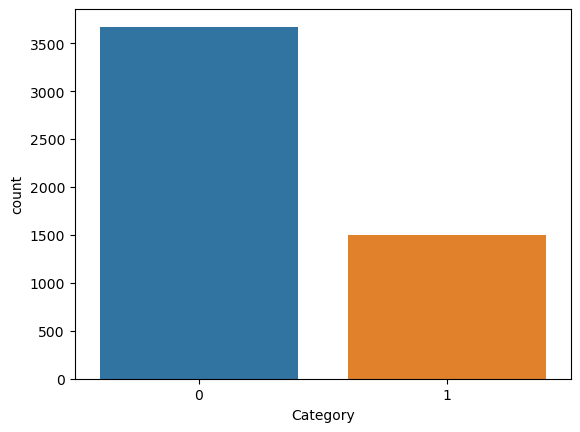

In [45]:
# Printing a graph showing the number of Spam emails vs. number of Non-Spam emails
sns.countplot(x='Category', data=data)
plt.show()

In [46]:
punctuations_list = string.punctuation

In [47]:
def remove_punctuations(text):
   temp = str.maketrans('', '', punctuations_list)
   return text.translate(temp)

In [48]:
data = data.dropna()
data['Message'] = data['Message'].apply(lambda x: remove_punctuations(x))
data.head()

,Category,Message
0,0,Subject ena sales on hpl\njust to update you o...
1,0,Subject 98 6736 98 9638 for 1997 ua 4 issu...
2,0,Subject hpl nominations for december 28 1999\...
3,0,Subject revised nom kcs resources\ndaren \nit...
4,0,Subject new production sitara deals needed\nd...


In [49]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)
    output = " ".join(imp_words)
    return output

In [50]:
# Sample of emails after having their stopwords and characters removed
data['Message'] = data['Message'].apply(lambda text: remove_stopwords(text))
data.head()

,Category,Message
0,0,subject ena sales hpl update project status ba...
1,0,subject 98 6736 98 9638 1997 ua 4 issues refer...
2,0,subject hpl nominations december 28 1999 see a...
3,0,subject revised nom kcs resources daren bob fo...
4,0,subject new production sitara deals needed dar...


In [51]:

data2 = FinalDF_STEM


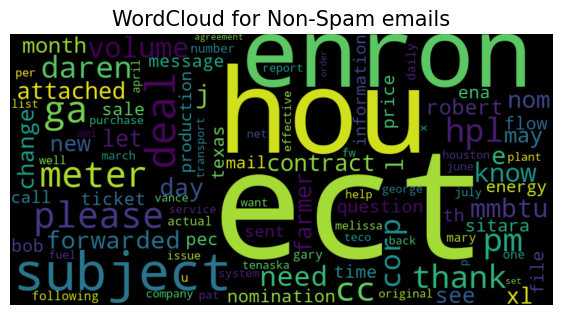

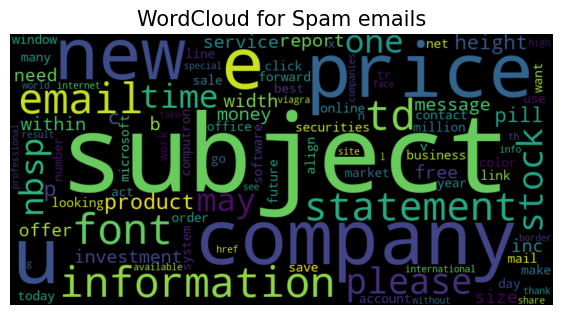

In [52]:
# Creating a word cloud visual of the most common words/tokens within each eamil type
email_corpus = " ".join(data[data['Category'] == 0]['Message'])
plt.figure(figsize=(7, 7))
wc = WordCloud(background_color='black',
               max_words=100,
               width=800,
               height=400,
               collocations=False).generate(email_corpus)

plt.imshow(wc, interpolation='bilinear')
plt.title(f'WordCloud for Non-Spam emails', fontsize=15)
plt.axis('off')
plt.show()



email_corpus = " ".join(data[data['Category'] == 1]['Message'])
plt.figure(figsize=(7, 7))
wc = WordCloud(background_color='black',
               max_words=100,
               width=800,
               height=400,
               collocations=False).generate(email_corpus)

plt.imshow(wc, interpolation='bilinear')
plt.title(f'WordCloud for Spam emails', fontsize=15)
plt.axis('off')
plt.show()

In [53]:
#train test split, using an 80/20 training data/testing data split
train_X, test_X, train_Y, test_Y = train_test_split(data['Message'],
                                                    data['Category'],
                                                    test_size = 0.2,
                                                    random_state = 42)

In [54]:
train_Y.head()

3164    0
2067    0
4717    1
2505    0
2268    0
Name: Category, dtype: int64

In [55]:

print("train_X.shape: ", train_X.shape)
print("test_X.shape:  ", test_X.shape)
print("train_Y.shape: ", train_Y.shape)
print("test_Y.shape:  ", test_Y.shape)

train_X.shape:  (4137,)
test_X.shape:   (1035,)
train_Y.shape:  (4137,)
test_Y.shape:   (1035,)


In [56]:
# Tokenize the data and preparing it for modeling
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Since each of the emails are of different lengths, and some very long, I included a variable that says what the maxium sequence length can be for the modeling process
max_len = 100
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
test_sequences = pad_sequences(test_sequences,
                               maxlen=max_len,
                               padding='post',
                               truncating='post')

In [57]:
# Building the TensorFlow model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32,
                                    input_length=max_len))
# Here you can control the number of layers/parameters that your model has. The more parameters = higher complexity and slower runtime of the model, but may also result in better model accuracy
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [58]:
model.build(input_shape=(None, max_len))  # None can be used for batch size, which is unspecified here
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 32)        │     1,429,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,433,281 (5.47 MB)

 Trainable params: 1,433,281 (5.47 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

In [60]:
es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [61]:
# Train the model
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20,
                    batch_size=32,
                    callbacks = [lr, es]
                   )

Epoch 1/20


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6861 - loss: 0.6291 - val_accuracy: 0.9527 - val_loss: 0.2043 - learning_rate: 0.0010
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9672 - loss: 0.1499 - val_accuracy: 0.9710 - val_loss: 0.1218 - learning_rate: 0.0010
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9794 - loss: 0.0948 - val_accuracy: 0.9749 - val_loss: 0.1146 - learning_rate: 0.0010
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9838 - loss: 0.0771 - val_accuracy: 0.9604 - val_loss: 0.1446 - learning_rate: 0.0010
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9727 - loss: 0.0934 - val_accuracy: 0.9604 - val_loss: 0.1514 - learning_rate: 0.0010
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9760 - loss: 0.0633 - val_accuracy: 0.9662 - val_loss: 0.1469 - learning_rate: 5.0000e-04


In [62]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

print(f'\nThe training accuracy turns out to be {test_accuracy*100:.2f}%, which is pretty good.')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9760 - loss: 0.1103
Test Loss : 0.1146063432097435
Test Accuracy : 0.9748792052268982

The training accuracy turns out to be 97.49%, which is pretty good.
